# Imports and read log

In [82]:
import numpy as np
from matplotlib import pyplot as plt

def read_train_log (log_file):
    """ 
    Reads log file, with KAIR structure (https://github.com/cszn/KAIR), and retrieves training/validation information.

    Args:
    - log_file (str): path to the log file containing the training information.

    Returns:
    - train_info (dict): dictionary with 'epochs' 'lr', 'iters' and 'loss' training information as arrays.
    - train_info (dict): dictionary with 'epochs' 'iters', 'avgloss' and 'avgPSNR' validation information as arrays.
    """

    # Initialize lists for train
    epoch_list = []
    lr_list = []
    iter_list = []
    loss_list = []

    # Initialize lists for val
    val_epoch_list = []
    val_iter_list = []
    val_avgloss_list = []
    val_avgPSNR_list = []

    # Read log file
    with open(log_file, 'r') as file:
        for line in file:

            # Training log line:
            # Filter log for train info ('Average' is included in test information)
            if '<epoch:' in line and not( 'Average' in line):
                epoch = int(line.split('<')[1].split('epoch:')[1].split(',')[0].strip())
                pre_iter = line.split('<')[1].split('iter:')[1].split(', lr')[0].strip()
                
                if ',' in pre_iter:
                    iter = 1000*int(pre_iter.split(',')[0]) + int(pre_iter.split(',')[1])
                else:
                    iter = int(pre_iter)
                lr = float(line.split('<')[1].split('lr:')[1].split('>')[0].strip())
                loss = float(line.split('G_loss:')[1])
                epoch_list.append(epoch)
                lr_list.append(lr)
                iter_list.append(iter)
                loss_list.append(loss)

            # Validation log line:
            # Filter log for train info ('Average' is included in test information)
            if ('<epoch:' in line) and ('Average' in line):
                epoch = int(line.split('<')[1].split('epoch:')[1].split(',')[0].strip())
                pre_iter = line.split('<')[1].split('iter:')[1].split(', lr')[0].strip()
                
                if ',' in pre_iter:
                    iter = 1000*int(pre_iter.split(',')[0]) + int(pre_iter.split(',')[1])
                else:
                    iter = int(pre_iter)

                avgPSNR = float(line.split('<')[1].split('PSNR :')[1].split('dB')[0].strip())
                avgloss = float(line.split('loss :')[1])

                val_epoch_list.append(epoch)
                val_iter_list.append(iter)
                val_avgloss_list.append(avgloss)
                val_avgPSNR_list.append(avgPSNR)

    # Lists to array
    epoch_array = np.array(epoch_list)
    lr_array = np.array(lr_list)
    iter_array = np.array(iter_list)
    loss_array = np.array(loss_list)

    val_epoch_array = np.array(val_epoch_list)
    val_iter_array = np.array(val_iter_list)
    val_avgloss_array = np.array(val_avgloss_list)
    val_avgPSNR_array = np.array(val_avgPSNR_list)

    train_info = {'epochs': epoch_array, 'lr': lr_array, 'iters':iter_array, 'loss':loss_array}
    val_info = {'epochs': val_epoch_array, 'iters':val_iter_array, 'loss':val_avgloss_array, 'PSNR':val_avgPSNR_array}

    return train_info, val_info


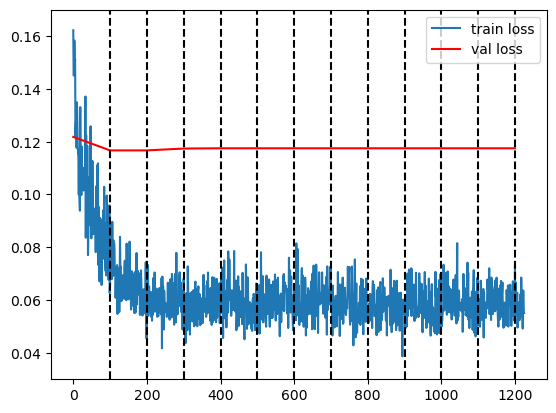

In [80]:
logfile = '/home/emidan19/Desktop/deep-tempest/drunet/baseline/real_imag_chs_capture/drunet_retrain/patch_128_l1loss/train.log'
train_info, val_info = read_train_log (logfile)

plt.figure()
plt.plot(train_info['loss'], label='train loss')
plt.plot(np.arange(1300,step=100), val_info['loss'],'r', label='val loss')
for i in range(1,13):
    plt.plot([i*100,i*100],[0.03,0.17],'--k')
plt.ylim(0.03,0.17)
plt.legend()
plt.show()

In [ ]:
tmp_epoch = 0
for i,epoch in enumerate(train_info['epochs']):
    if tmp_epoch>=epoch:
        train_info['epochs'][i] += tmp_epoch
        # epoch += tmp_epoch
    tmp_epoch += 1
plt.figure()
plt.plot(train_info['epochs'])
plt.show()